In [1]:
# Python imports
import sys, numpy as np
# Torch
import torch, torchvision, torch.nn as nn, torch.optim as optim
# Navigation MDP
import navigation_mdp as NvMDP
# RL utils
import rl.planning as Plan
import rl.policy as Policy
from rl.model import RewardLinear, RewardConvAE, RewardConvFCAE
from irl.mlirl.mlirl import run_mlirl
# Utils
from utils.navgw import NavigationGridWorld
from utils.utils import *
from utils.plotting import NavGridViewPlotter as NvPlotter, plot_grid_data_helper
# Matplotlib
from matplotlib import cm as cm, pyplot as plt, colors as mplotcolors
%load_ext autoreload
%autoreload 2

## Satellite Image World

Note: image clipped to: (600, 800, 3)


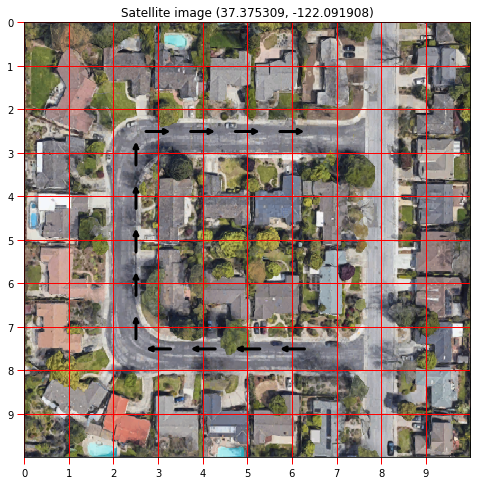

In [2]:
import cv2
import navigation_vis.Raster as NavGridView

img = cv2.imread("./Datasets/GoogleSatellite/goog_satimg_37.375309_-122.091908.png")[:,:,::-1]
img = cv2.resize(img, (800, 600))
# plt.imshow(img)
img_dtizer = NvMDP.features.ImageDiscretizer(img, 10, 10, (0,0))

# Expert demonstration
s_lst_lst = [[(7,6), (7,5), (7,4), (7,3), (7,2), 
              (6,2), (5,2), (4,2), (3,2), 
              (2,2), (2,3), (2,4), (2,5), (2,6)]]

plt.figure(figsize=(8,8))
NavGridView.Raster(img_dtizer() / 255.).render().ticks(minor=False).grid().add_trajectories(
    [[(s[1], s[0]) for s in s_lst ] for s_lst in s_lst_lst ], 
    arrow_props={"lw": 3, "color": "black", "shrinkB":10, "shrinkA":10}).title("Satellite image (37.375309, -122.091908)")

##  Setup MDP\R

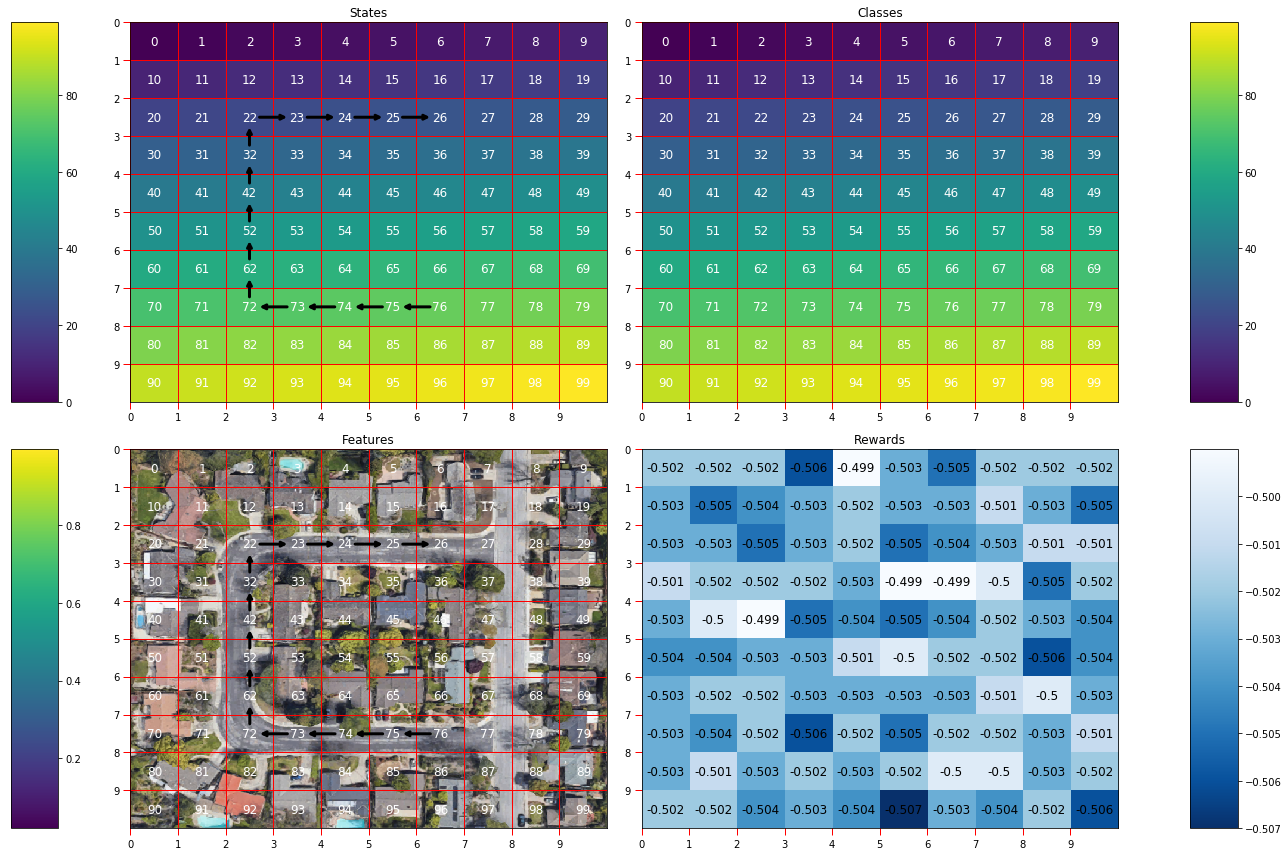

In [3]:
nvgw = NavigationGridWorld(
                H=10, 
                W=10, 
                xyclass_dist=np.arange(10 * 10).reshape(10, 10).tolist(), 
                terminal_loc_lst=[])
nvgw.attach_features(loc_to_array_fn=lambda row, col: img_dtizer.get_image_cell(row, col)/255.)
R_model = RewardConvAE(nvgw.get_feature_shape()[1:], z_dim=300, lr=0.01, weight_decay=0.)
# print(R_model)
# # img_dtizer().shape, PHI.shape
# from torchsummary import summary
# summary(R_model, PHI.shape[1:])
nvgw.attach_rewards(R_model)
nvgw.add_trajectories(s_lst_lst)
nvgw.plot_world()

In [4]:
log_likelihoods_history, R_curr, VI_by_goal = run_mlirl(
    nvgw.demonstrations(), nvgw.S, nvgw.features(), nvgw.dynamics(), nvgw.r_model, boltzmann_temp=0.1)

Running VI (goal: (2, 6))
Setting goal as terminal state!
Learning values [  ] Converged @ 16.
Reasoning [  0 30 49 ] Done.
>>> Iter: 0000 (3.073s): loss = 33.796387, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  ] Converged @ 16.
Reasoning [  0 30 49 ] Done.
>>> Iter: 0001 (3.086s): loss = 34.282211, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  ] Converged @ 17.
Reasoning [  0 30 49 ] Done.
>>> Iter: 0002 (2.945s): loss = 27.003441, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  ] Converged @ 16.
Reasoning [  0 30 49 ] Done.
>>> Iter: 0003 (2.986s): loss = 16.803616, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  30 ] Converged @ 51.
Reasoning [  0 30 49 ] Done.
>>> Iter: 0004 (4.006s): loss = 16.612669, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  30 ] Converged @ 37.
Reasoning [  0 30 49 ] Done.
>>> Iter: 0005 (3.555s): loss = 17.793354, likelihood = 0.0000


Running VI (goal: (2

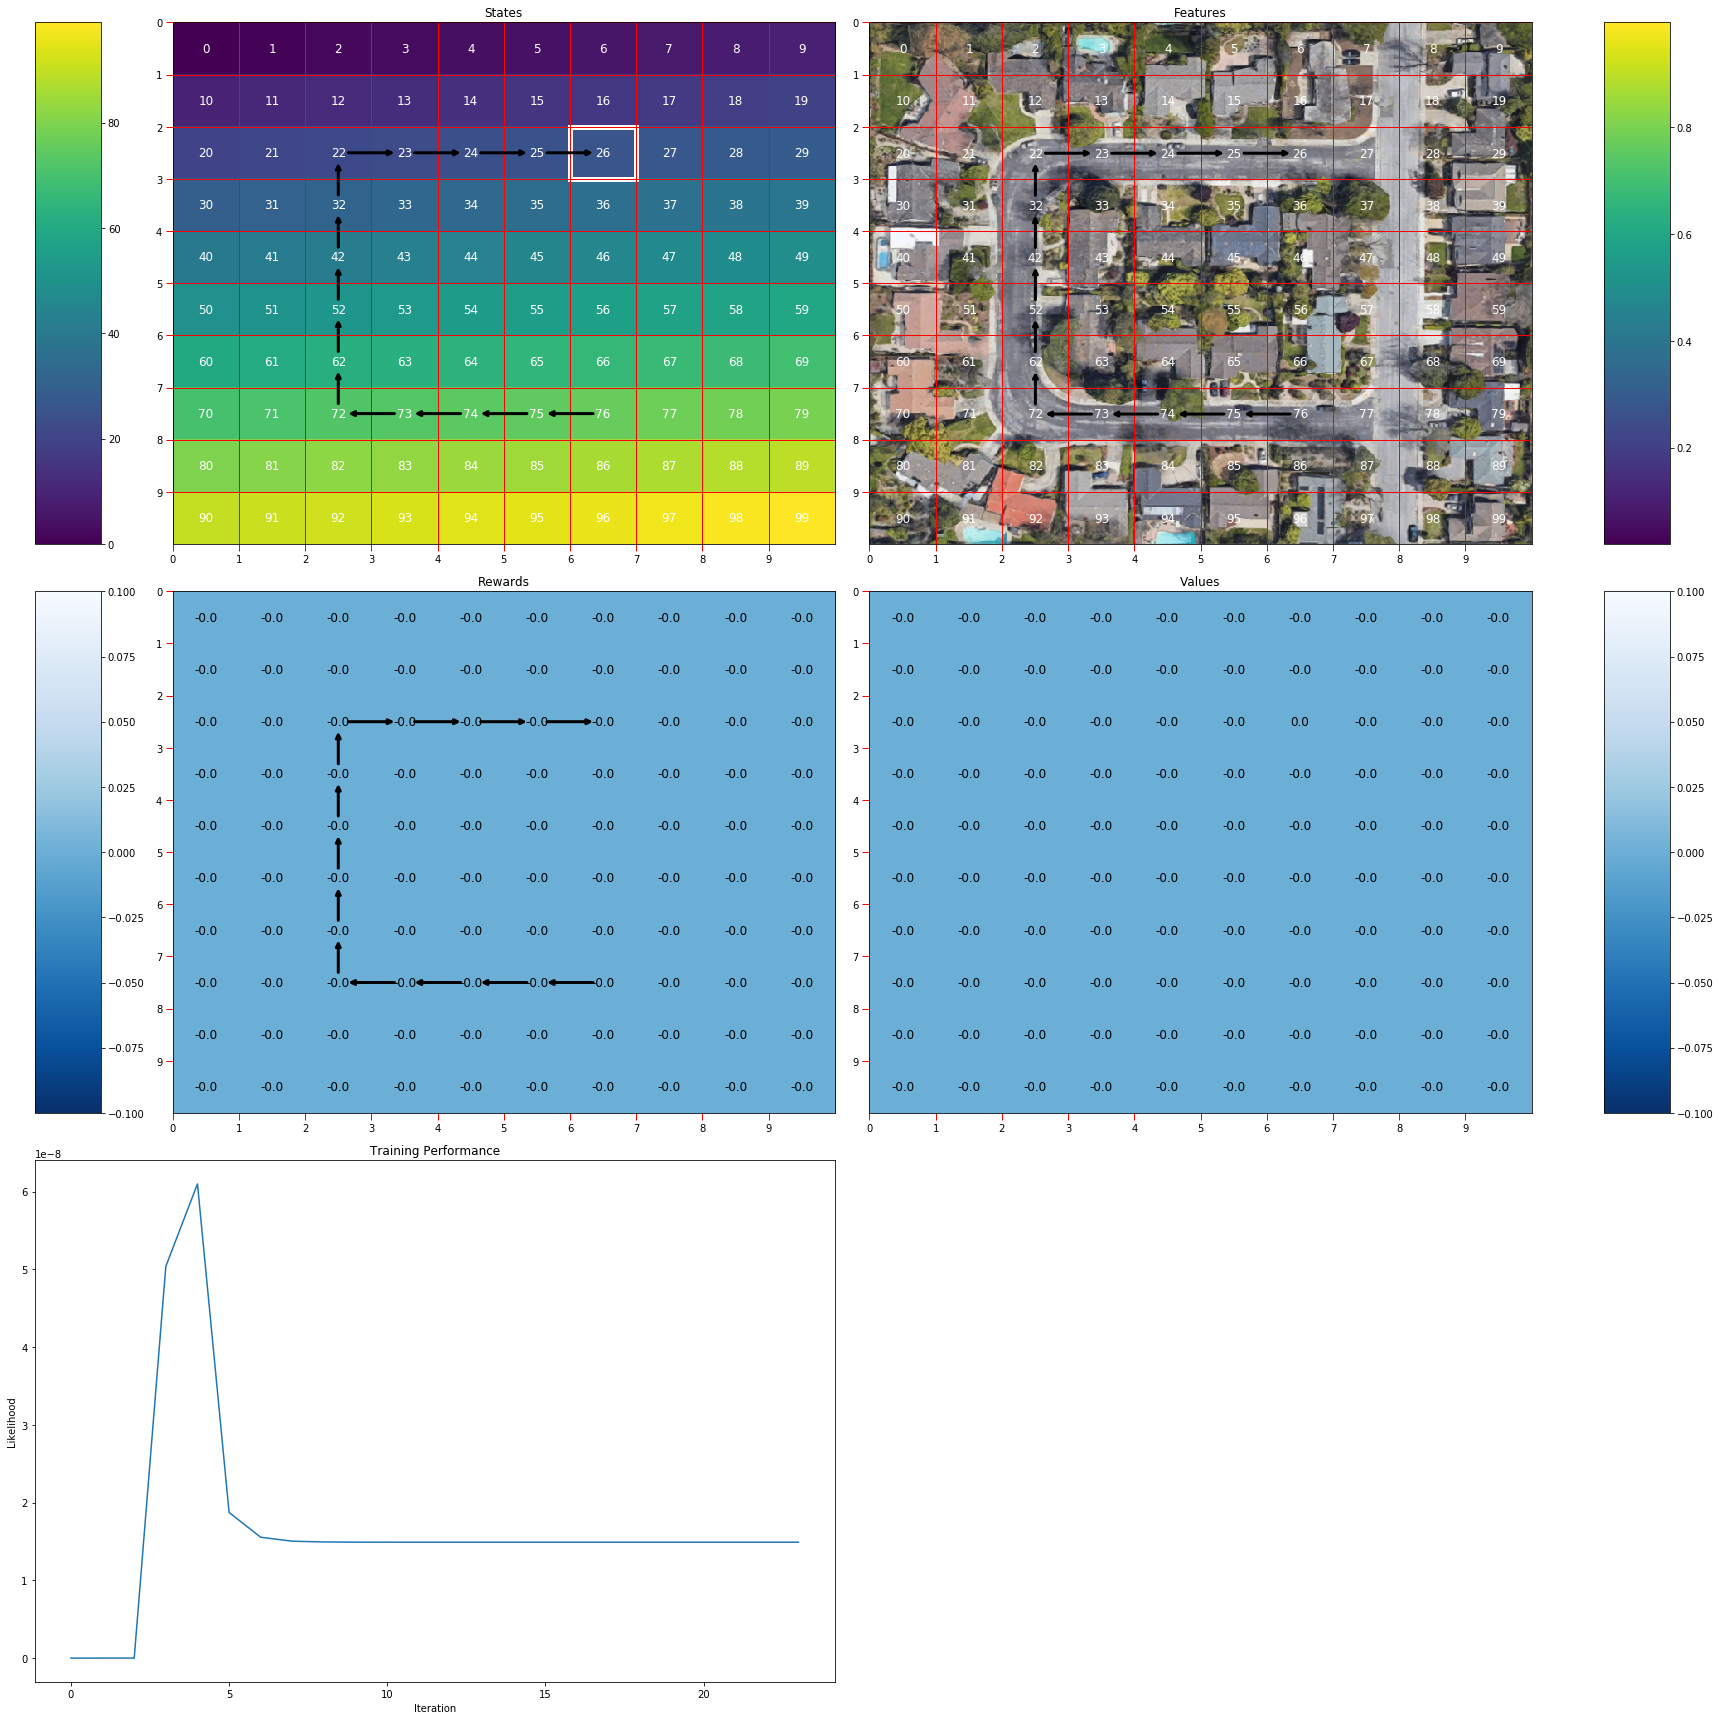

In [5]:
VI = VI_by_goal[s_lst_lst[0][-1]]
nvgw.plot_results(VI.V.detach().numpy().round(3), log_likelihoods_history)
plt.savefig("./figures/mlirl_gridworld_10x10_sat_img__traj_2_turns__degeneracy.png")

## Validate with one-hot features

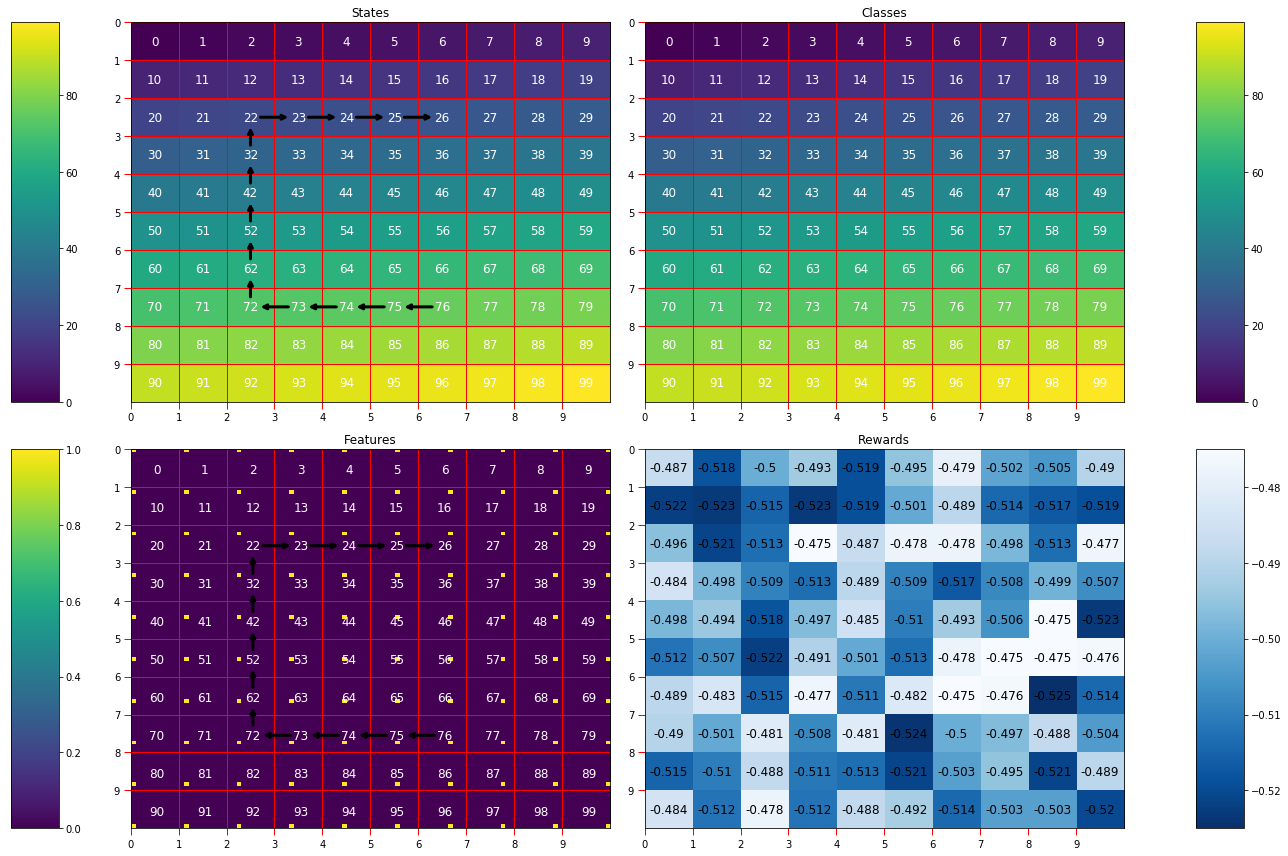

In [7]:
nvgw = NavigationGridWorld(
                H=10, 
                W=10, 
                xyclass_dist=np.arange(10 * 10).reshape(10, 10).tolist(), 
                terminal_loc_lst=[])
nvgw.attach_onehot_features()
R_model = RewardLinear(nvgw.get_feature_shape()[0], lr=0.1, weight_decay=0.)
nvgw.attach_rewards(R_model)
nvgw.add_trajectories(s_lst_lst)
nvgw.plot_world()

In [8]:
log_likelihoods_history, R_curr, VI_by_goal = run_mlirl(
    nvgw.demonstrations(), nvgw.S, nvgw.features(), nvgw.dynamics(), nvgw.r_model, boltzmann_temp=0.01)

Running VI (goal: (2, 6))
Setting goal as terminal state!
Learning values [  0
	 ] Converged @ 14.
Reasoning [  0 30 49 ] Done.
>>> Iter: 0000 (2.629s): loss = 290.365906, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0
	 ] Converged @ 13.
Reasoning [  0 30 49 ] Done.
>>> Iter: 0001 (2.927s): loss = 255.862274, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0
	 ] Converged @ 13.
Reasoning [  0 30 49 ] Done.
>>> Iter: 0002 (2.732s): loss = 221.967682, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0
	 ] Converged @ 13.
Reasoning [  0 30 49 ] Done.
>>> Iter: 0003 (2.943s): loss = 186.983047, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0
	 ] Converged @ 12.
Reasoning [  0 30 49 ] Done.
>>> Iter: 0004 (2.715s): loss = 154.223541, likelihood = 0.0000


Running VI (goal: (2, 6))
Learning values [  0
	 ] Converged @ 12.
Reasoning [  0 30 49 ] Done.
>>> Iter: 0005 (2.781s): loss = 122.232086, likelihood = 0.000

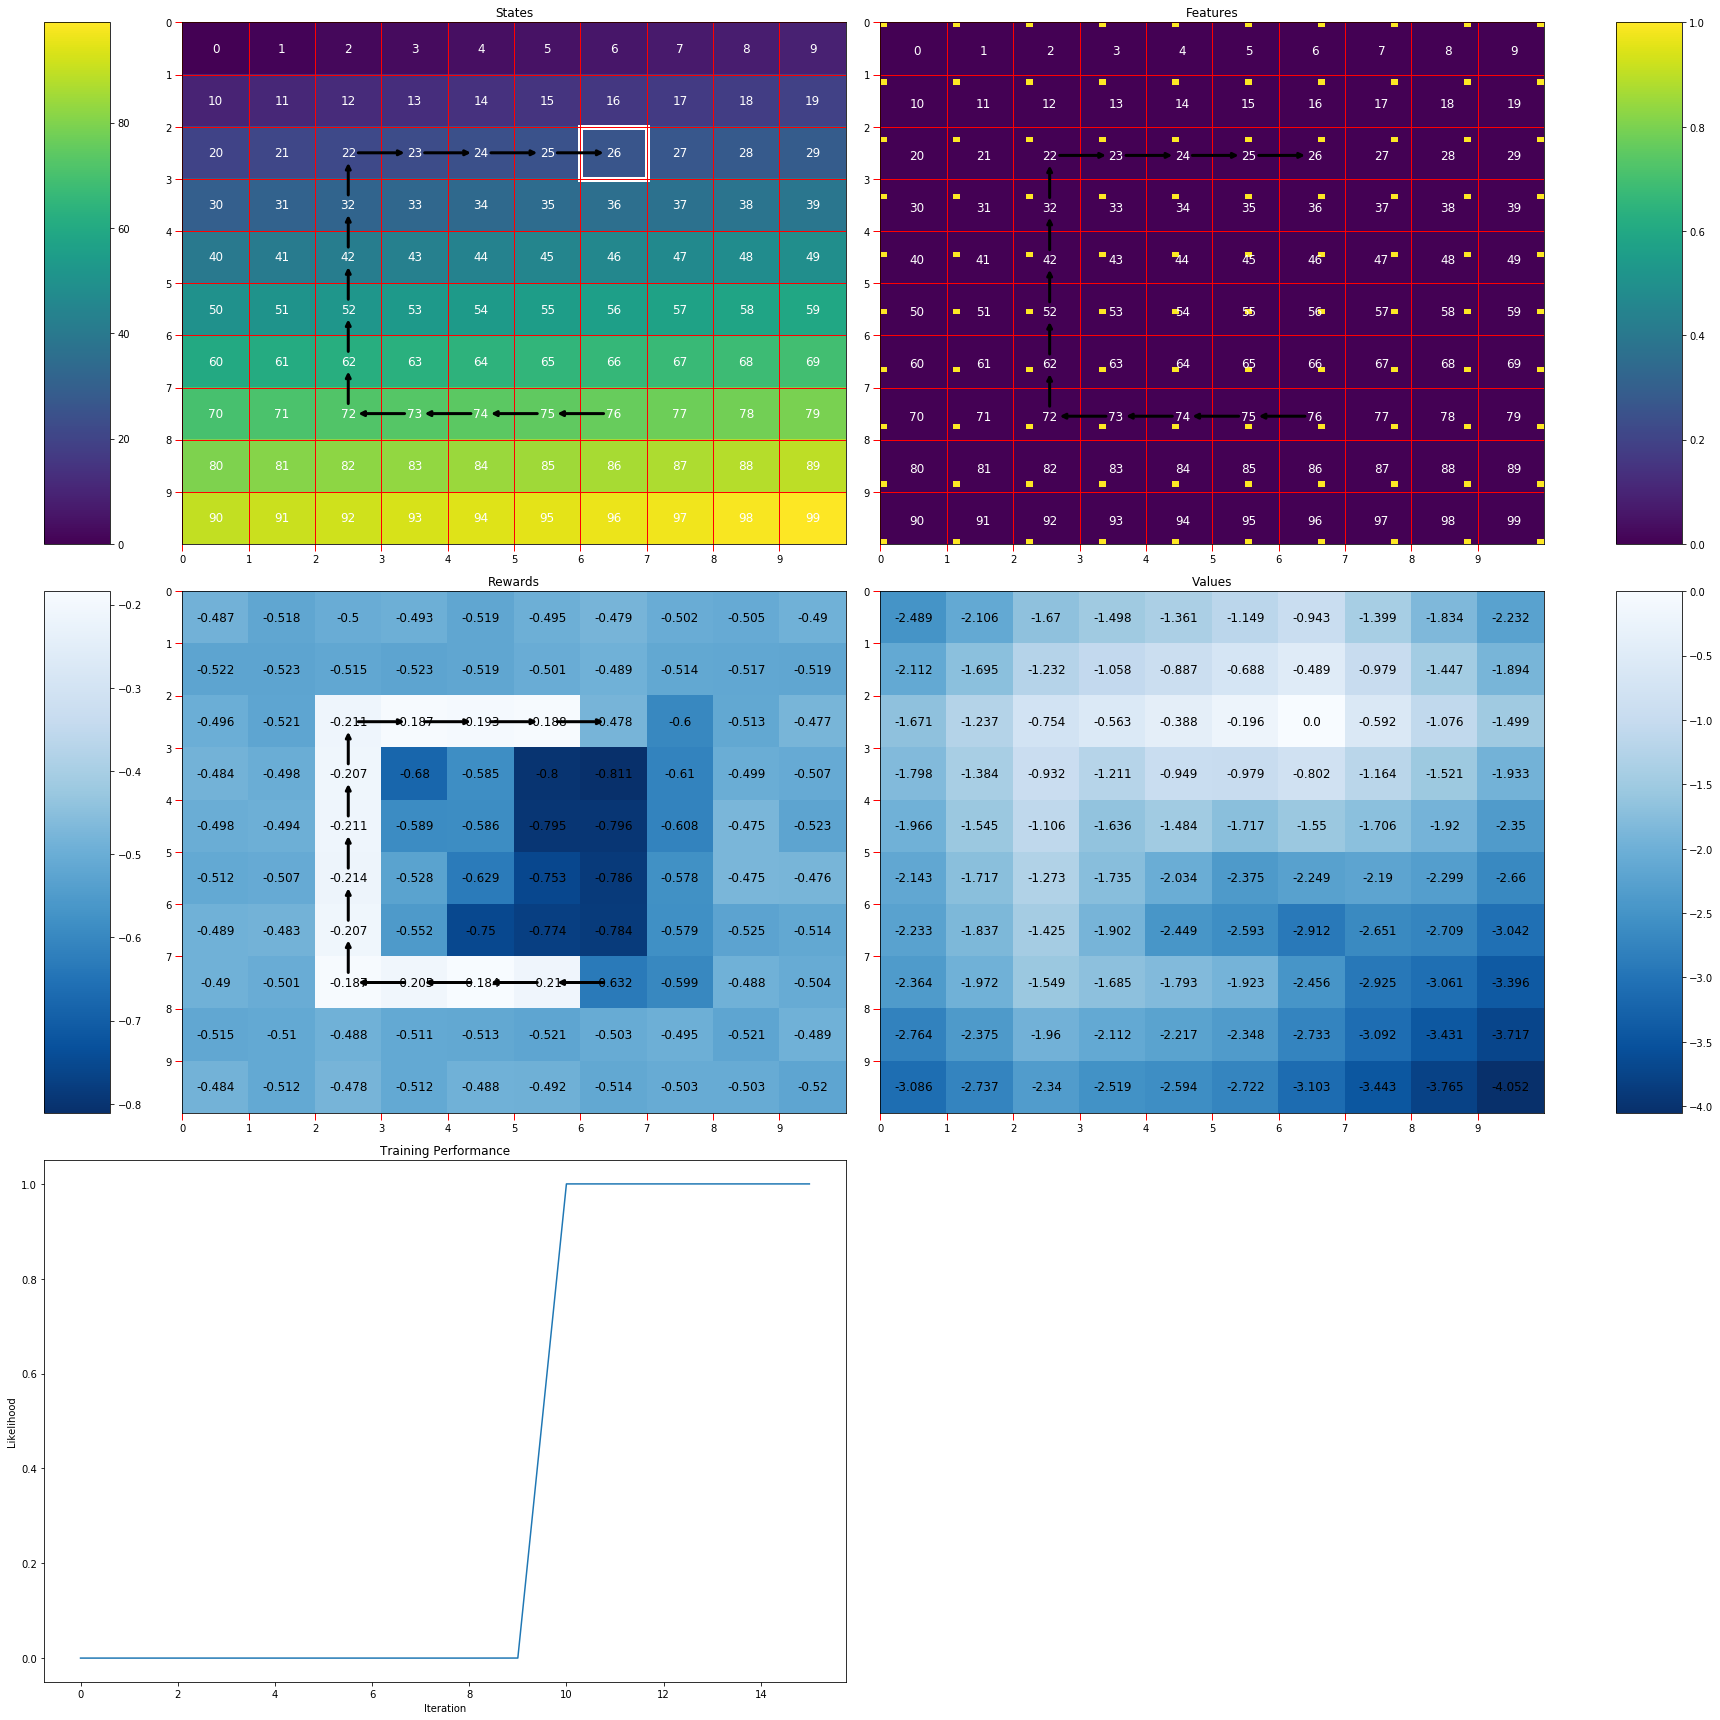

In [9]:
VI = VI_by_goal[s_lst_lst[0][-1]]
nvgw.plot_results(VI.V.detach().numpy().round(3), log_likelihoods_history)
plt.savefig("./figures/mlirl_gridworld_10x10_one_hot__traj_2_turns")

In [11]:
np.save("./data/mlirl_gridworld_10x10_one_hot__traj_2_turns__rewards.npy", R_curr.detach().numpy())